# Conceptrol on SDXL + IP-Adapter

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from PIL import Image
import torch

from ip_adapter import ConceptrolIPAdapterPlusXL, IPAdapterPlusXL
from ip_adapter.custom_pipelines import StableDiffusionXLCustomPipeline

In [2]:
def image_grid(imgs, rows, cols, res=256):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    h_res = int(res * h / w)
    grid = Image.new('RGB', size=(cols*res, rows*h_res))

    for i, img in enumerate(imgs):
        grid.paste(img.resize((res, h_res)), box=(i%cols*res, i//cols*h_res))
    return grid

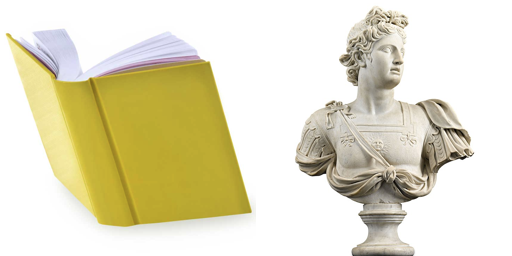

In [3]:
book_image = Image.open("demo/book.jpg")
statue_image = Image.open("demo/statue.jpg")

image_grid([book_image, statue_image], 1, 2)

In [4]:
# base_model_path = "RunDiffusion/Juggernaut-XL-v9"
base_model_path = "SG161222/RealVisXL_V5.0"
# base_model_path = "stabilityai/stable-diffusion-xl-base-1.0"
image_encoder_path = "../human-centric-adapter/models/image_encoder"
ip_adapter_path = "../human-centric-adapter/sdxl_models/ip-adapter-plus_sdxl_vit-h.bin"
device = "cuda"
seed = 1002

# IP-Adapter

In [5]:
pipe = StableDiffusionXLCustomPipeline.from_pretrained(
    base_model_path,
    # variant="fp16",
    torch_dtype=torch.float16,
    feature_extractor=None
)
ip_pipe = IPAdapterPlusXL(pipe, image_encoder_path, ip_adapter_path, device, num_tokens=16)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/qiyuan/Conceptrol/ip_adapter/ip_adapter.py:156: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(self.ip_ckpt, map_location="cpu")


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Left to Right: [Reference of Book, Reference of Statue, Use Book, Use Statue, Use Book and Statue]


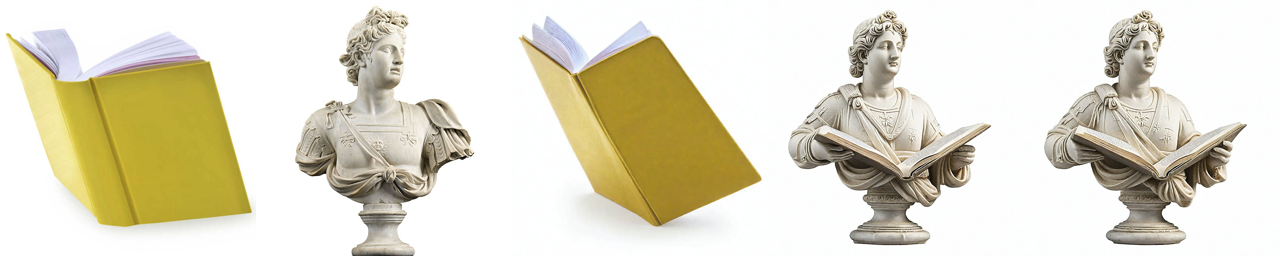

In [6]:
prompt = "A statue is reading the book in the cafe, best quality, high quality"
negative_prompt = "deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality"

images = [book_image]

ip_book = ip_pipe.generate(prompt=prompt, pil_images=images, num_samples=1, num_inference_steps=50,
                            scale=0.6, negative_prompt=negative_prompt, control_guidance_start=0.0, seed=seed)

images = [statue_image]

ip_statue = ip_pipe.generate(prompt=prompt, pil_images=images, num_samples=1, num_inference_steps=50,
                            scale=0.6, negative_prompt=negative_prompt, control_guidance_start=0.0, seed=seed)

images = [book_image, statue_image]

ip_compositional = ip_pipe.generate(prompt=prompt, pil_images=images, num_samples=1, num_inference_steps=50,
                            scale=0.6, negative_prompt=negative_prompt, control_guidance_start=0.0, seed=seed)

print("Left to Right: [Reference of Book, Reference of Statue, Use Book, Use Statue, Use Book and Statue]")
ip_results = image_grid([book_image, statue_image, ip_book[0], ip_statue[0], ip_compositional[0]], 1, 5)
ip_results

# Conceptrol

In [7]:
pipe = StableDiffusionXLCustomPipeline.from_pretrained(
    base_model_path,
    # variant="fp16",
    torch_dtype=torch.float16,
    feature_extractor=None
)
conceptrol_pipe = ConceptrolIPAdapterPlusXL(pipe, image_encoder_path, ip_adapter_path, device, num_tokens=16, global_masking=True)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/qiyuan/Conceptrol/ip_adapter/ip_adapter.py:366: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(self.ip_ckpt, map_location="cpu")


Locate: book 6 7


  0%|          | 0/50 [00:00<?, ?it/s]

Locate: statue 2 3


  0%|          | 0/50 [00:00<?, ?it/s]

Locate: book 6 7
Locate: statue 2 3


  0%|          | 0/50 [00:00<?, ?it/s]

Left to Right: [Reference of Book, Reference of Statue, Use Book, Use Statue, Use Book and Statue]


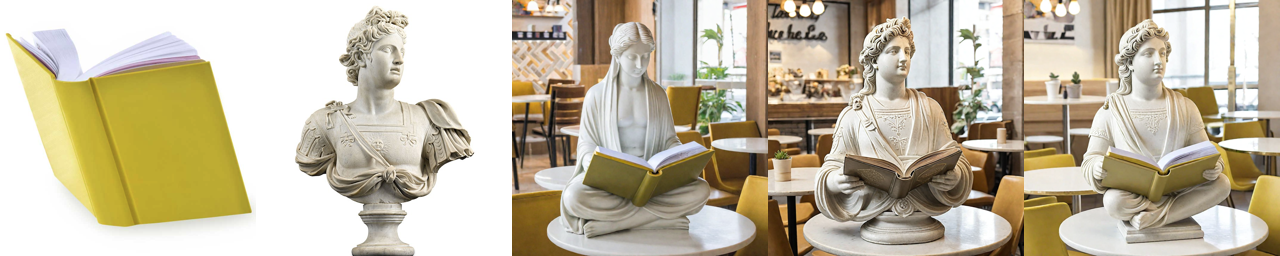

In [8]:
prompt = "A statue is reading the book in the cafe, best quality, high quality"
negative_prompt = "deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality"

images = [book_image]
concepts = ["book"]

conceptrol_book = conceptrol_pipe.generate(prompt=prompt, pil_images=images, subjects=concepts, num_samples=1, num_inference_steps=50,
                            scale=1.0, negative_prompt=negative_prompt, control_guidance_start=0.2, seed=seed)

images = [statue_image]
concepts = ["statue"]

conceptrol_statue = conceptrol_pipe.generate(prompt=prompt, pil_images=images, subjects=concepts, num_samples=1, num_inference_steps=50,
                            scale=1.0, negative_prompt=negative_prompt, control_guidance_start=0.2, seed=seed)

images = [book_image, statue_image]
concepts = ["book", "statue"]

conceptrol_compositional = conceptrol_pipe.generate(prompt=prompt, pil_images=images, subjects=concepts, num_samples=1, num_inference_steps=50,
                            scale=1.0, negative_prompt=negative_prompt, control_guidance_start=0.2, seed=seed)

print("Left to Right: [Reference of Book, Reference of Statue, Use Book, Use Statue, Use Book and Statue]")
conceptrol_results = image_grid([book_image, statue_image, conceptrol_book[0], conceptrol_statue[0], conceptrol_compositional[0]], 1, 5)
conceptrol_results

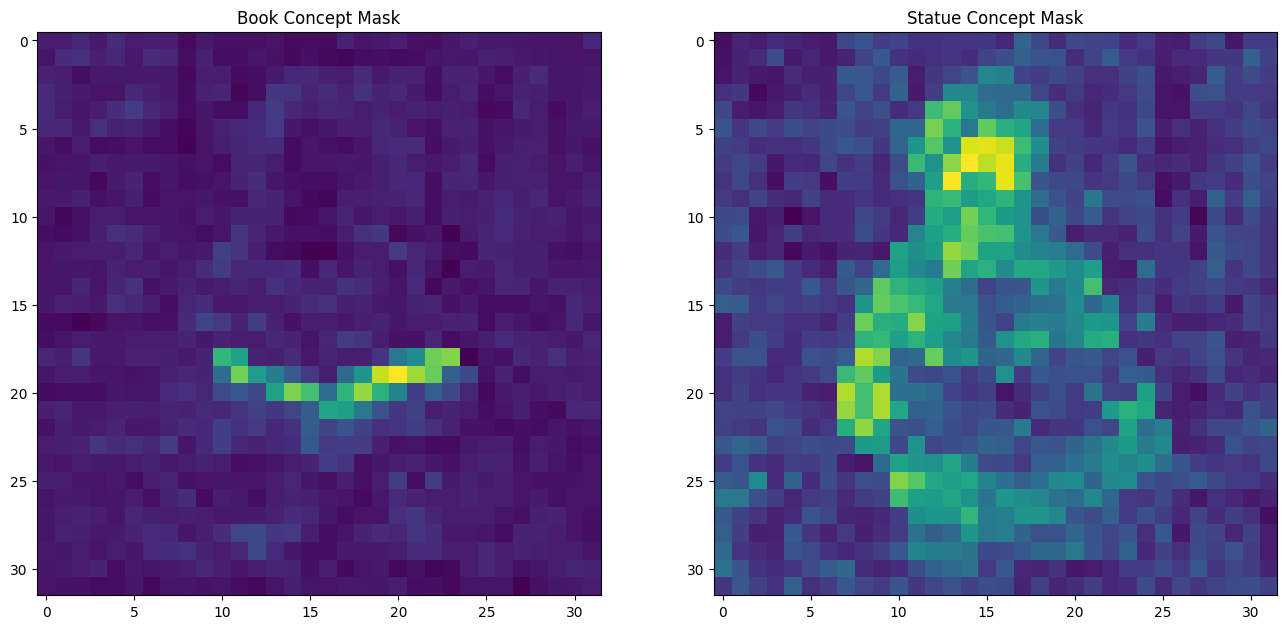

In [9]:
import ip_adapter.attention_processor as ap
import matplotlib.pyplot as plt

book_mask = ap.global_concept_mask[0]
book_mask = book_mask.reshape((32, 32)).cpu().numpy()

statue_mask = ap.global_concept_mask[1]
statue_mask = statue_mask.reshape((32, 32)).cpu().numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

im1 = ax1.imshow(book_mask)
ax1.set_title('Book Concept Mask')

im2 = ax2.imshow(statue_mask)
ax2.set_title('Statue Concept Mask')

plt.show()


# Comparison of all

Comparison of all, Top: wo/Conceptrol; Bottom: w/Conceptrol


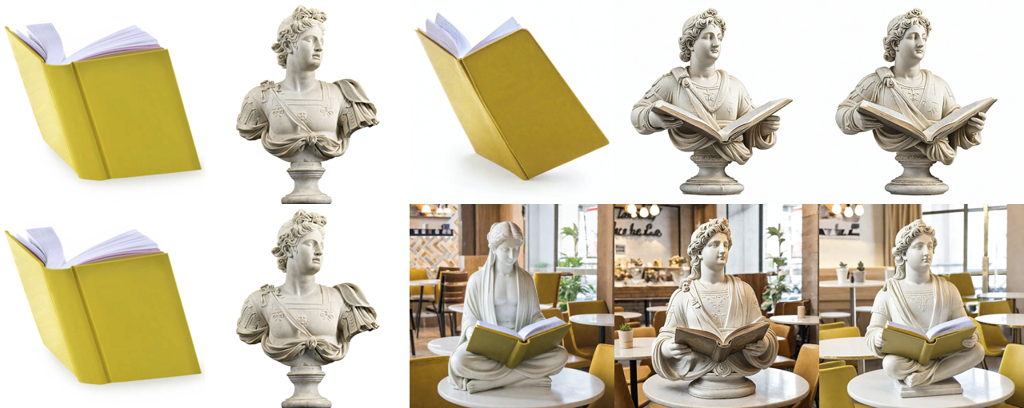

In [10]:
print("Comparison of all, Top: wo/Conceptrol; Bottom: w/Conceptrol")

results_all = image_grid([ip_results, conceptrol_results], 2, 1, res=1024)
results_all